In [30]:
''' Imports '''
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.integrate import trapezoid

In [31]:
'''Parzen Kernel function'''
def parzen_kde(vals, x_vals, bandwidth):
    n = len(vals)
    densities = []

    for x in x_vals:
        count = np.sum(np.abs((vals - x) / bandwidth) <= 1)
        density = count / (n * bandwidth)
        densities.append(density)

    return np.array(densities)

In [32]:
'''Global var'''
TO_FEW = 5
LOWEST_VAR = 1e-5
DATA_SOURCE = '../data/source.csv'

In [33]:
'''Loading and displayng few records'''
source_file = pd.read_csv(DATA_SOURCE, index_col=0)
source_file.head()

,Serial,Source,X1,X2,X3,X4,X5,X6,X7,-01,...,ong,ong-,ria,rial,ser,seri,seria,tol,tolo,tolon
index,,,,,,,,,,,,,,,,,,,,,
0,MNOJUE-084279,isOK,6,6,6,0,13,6,0,0,...,0,0,0,0,0,0,0,0,0,0
1,JKLPDY12-13,isOK,6,4,4,0,11,6,0,0,...,0,0,0,0,0,0,0,0,0,0
2,WDS49kAUY,isNotOK,7,2,2,0,9,6,1,0,...,0,0,0,0,0,0,0,0,0,0
3,MNORSP-063772,isOK,6,6,6,0,13,6,0,0,...,0,0,0,0,0,0,0,0,0,0
4,MNOMPN-021264,isOK,6,6,6,0,13,6,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
''' Binary lable selecting only features columns'''

source_file["label"] = source_file["Source"].map({"isOK": 0, "isNotOK": 1})

feature_cols = source_file.select_dtypes(include=[np.number]).columns.drop(["index", "label"], errors='ignore')

In [35]:
'''Drop low var columns'''
low_var_cols = source_file[feature_cols].var() < LOWEST_VAR
feature_cols = feature_cols[~low_var_cols]

In [ ]:
'''Dleta Calculation'''
delta_scores = {}
best_bandwidths = {}
delta_values = []
h_values = list(range(5, 31))

for feature in tqdm(feature_cols, desc="Obliczanie delta_j (Parzen, h 5–30)"):

    ok_vals = source_file[source_file["label"] == 0][feature].dropna().values
    err_vals = source_file[source_file["label"] == 1][feature].dropna().values

    if len(ok_vals) < TO_FEW or len(err_vals) < TO_FEW:
        continue

    x_min = min(ok_vals.min(), err_vals.min())
    x_max = max(ok_vals.max(), err_vals.max())
    x_vals = np.linspace(x_min, x_max, 100)

    best_delta = -1
    best_h = None

    for h in h_values:
        kde_ok = parzen_kde(ok_vals, x_vals, h)
        kde_err = parzen_kde(err_vals, x_vals, h)

        diff_squared = (kde_ok - kde_err) ** 2
        delta_j = trapezoid(diff_squared, x_vals)
        delta_values.append(delta_j)

        if delta_j > best_delta:
            best_delta = delta_j
            best_h = h

    delta_scores[feature] = best_delta
    best_bandwidths[feature] = best_h


Obliczanie delta_j (Parzen, h 5–30): 100%|██████████| 107/107 [00:10<00:00, 10.36it/s]


ValueError: x and y must have same first dimension, but have shapes (26,) and (2782,)

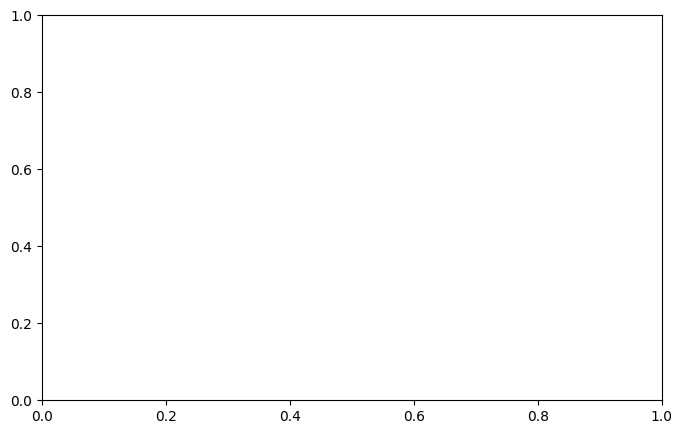

In [37]:
plt.figure(figsize=(8, 5))
plt.plot(h_values, delta_values, marker='o', color='dodgerblue')
plt.title(f"Delta vs Bandwidth (cecha: {feature})")
plt.xlabel("Bandwidth (h)")
plt.ylabel("Delta")
plt.grid(True)
plt.tight_layout()

In [ ]:
# Posortuj cechy od najbardziej istotnych
sorted_features = sorted(delta_scores.items(), key=lambda x: x[1], reverse=True)

# Zamień na DataFrame (opcjonalnie)
import pandas as pd
delta_df = pd.DataFrame(sorted_features, columns=['feature', 'delta_j'])

# Wyświetl top 10
print(delta_df.head(10))

  feature   delta_j
0      X1  0.059711
1      X6  0.058605
2      X5  0.058232
3      X2  0.033780
4      X3  0.033780
5      X4  0.000000
6      X7  0.000000
7     -01  0.000000
8     -02  0.000000
9     -03  0.000000
